# Regression modelling

Here we don't consider the data as a time series, we only use regression to predict the net load from the month, hour, year or weather.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

from green_city.utils import span
from green_city.plotting import plot_decomposition
from green_city.mlflow_config import get_mlflow_config

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [99]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [100]:
## MLFLOW ##
try:
    import mlflow
    from green_city.mlflow_config import get_mlflow_config

    flow_conf = get_mlflow_config()
    tracking_uri = flow_conf["TRACKING_URI"]
    mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
    mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);
except:
    print("mlflow ui not active")

In [101]:
# ## DB CONNECTION ##
# from sqlalchemy import create_engine
# from decouple import Config, RepositoryEnv

# config = Config(RepositoryEnv("../.db_credentials"))

# db_connection_credentials = {
#     "database": config('POSTGRES_DB'),
#     "user": config('POSTGRES_USER'),
#     "password": config('POSTGRES_PASSWORD'),
#     "host": config('POSTGRES_HOST'),
#     "port": config('POSTGRES_PORT'),
# }
# DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
# db = create_engine(DB_STRING)

In [102]:
building_nr = 5
column_to_predict = "net_load_kW"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building nr": building_nr,
    "predicted feature": column_to_predict,
    "resolution": "daily",
}

In [103]:
# Load data
df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [104]:
# Shift predicted weather values by 24hr
df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)
df = df.dropna()

df['hour'] = df.index.hour
df['month'] = df.index.month
df['year'] = df.index.year

0.997497569581727


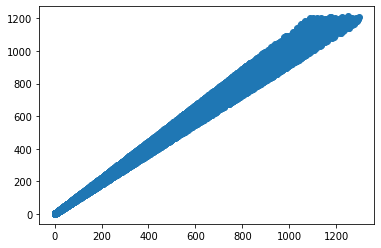

In [105]:
plt.scatter(x=df['pred_24h_direct_solar_W_m2_shift'], y=df['direct_solar_W_m2'])
print(df['pred_24h_direct_solar_W_m2_shift'].corr(df['direct_solar_W_m2']))

0.9943115239566656


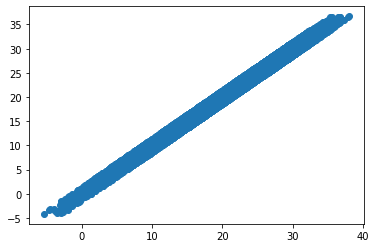

In [106]:
plt.scatter(x=df['pred_24h_outdoor_temp_shift'], y=df['outdoor_temp'])
print(df['pred_24h_outdoor_temp_shift'].corr(df['outdoor_temp']))

## Correlation matrix

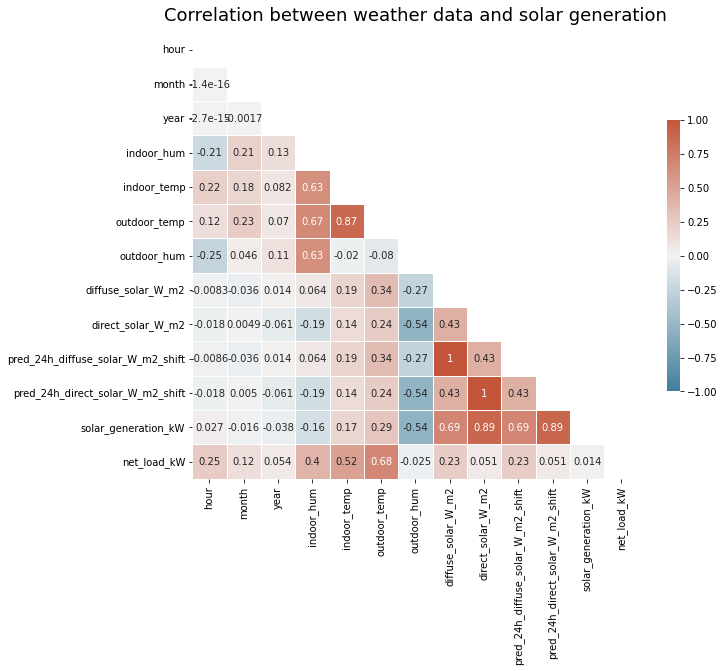

In [107]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
corr_weather= df[['hour','month','year','indoor_hum','indoor_temp','outdoor_temp','outdoor_hum', 'diffuse_solar_W_m2', 
                    'direct_solar_W_m2', 'pred_24h_diffuse_solar_W_m2_shift', 
                    'pred_24h_direct_solar_W_m2_shift', 'solar_generation_kW','net_load_kW']].corr()
mask = np.triu(np.ones_like(corr_weather, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(corr_weather, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
heatmap.set_title('Correlation between weather data and solar generation', fontdict={'fontsize':18}, pad=12);


## Train test split

In [108]:
df_train = df.iloc[:(len(df)-365*24)]   # First 3 years as train data
df_test = df.iloc[(len(df)-365*24):]    # Last year as test data

#features = ['hour', 'month']
#features = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2']
features = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2', 'hour', 'month']
target = 'net_load_kW'

X = df[features]
y = df[target]

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

## Regression modelling

### Multiple linear regression model using "measured" weather conditions to predict net energy usage

In [109]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Calculate r-squared for train data
y_pred_train = lin_reg.predict(X_train)
print("R-squared (train):", r2_score(y_train, y_pred_train).round(3))
df_train['net_load_kW_linreg_forecast'] = y_pred_train

# Calculate r-squared for test data
y_pred_test = lin_reg.predict(X_test)
print("R-squared (test):", r2_score(y_test, y_pred_test).round(3))
df_test['net_load_kW_linreg_forecast'] = y_pred_test

# Calculate r-squared for all data
y_pred = lin_reg.predict(X)
print("R-squared (all data):", r2_score(y, y_pred).round(3))
df['net_load_kW_forecast'] = y_pred


R-squared (train): 0.515
R-squared (test): 0.48
R-squared (all data): 0.507


In [110]:
print(f"Mean Absolute Error = {mean_absolute_error(y_test, y_pred_test).round(3)}")
print(f"Mean Squared Error = {mean_squared_error(y_test, y_pred_test).round(3)}")
print(f"MAPE = {mean_absolute_percentage_error(y_test, y_pred_test).round(3)}")


Mean Absolute Error = 6.406
Mean Squared Error = 64.325
MAPE = 228.612


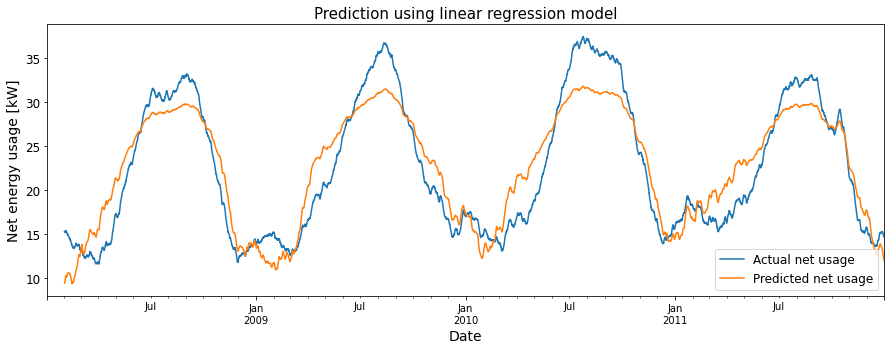

In [111]:
fig, ax = plt.subplots(figsize=(15,5))
df['net_load_kW'].rolling(24*30).mean().plot(label="Actual net usage")
df['net_load_kW_forecast'].rolling(24*30).mean().plot(label="Predicted net usage")
plt.legend(loc='lower right', fontsize=12)
plt.ylabel('Net energy usage [kW]', fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel('Date', fontsize=14)
plt.title('Prediction using linear regression model', fontsize=15)
plt.show()

### Multiple regression model with 5 polynomial features using "measured" weather conditions

In [112]:
n = 5
poly = PolynomialFeatures(degree=n, include_bias=False)

poly_features = poly.fit_transform(X_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
y_pred_train = poly_reg_model.predict(poly_features)
print("n:", n," R-squared (train):", r2_score(y_train, y_pred_train).round(3))
df_train['net_load_kW_poly_forecast'] = y_pred_train


poly_features = poly.fit_transform(X_test)
y_pred_test = poly_reg_model.predict(poly_features)
print("n:", n," R-squared (test):", r2_score(y_test, y_pred_test).round(3))
df_test['net_load_kW_poly_forecast'] = y_pred_test


poly_features = poly.fit_transform(X)
y_pred = poly_reg_model.predict(poly_features)
print("n:", n," R-squared (all data):", r2_score(y, y_pred).round(3))
df['net_load_kW_poly_forecast'] = y_pred

n: 5  R-squared (train): 0.861
n: 5  R-squared (test): 0.82
n: 5  R-squared (all data): 0.852


In [113]:
mae_poly = mean_absolute_error(y_test, y_pred_test).round(3)
mse_poly = mean_squared_error(y_test, y_pred_test).round(3)
print(f"Mean Absolute Error = {mae_poly}")
print(f"Mean Squared Error = {mse_poly}")

print("MAPE =", mean_absolute_percentage_error(y_test, y_pred_test).round(3))

Mean Absolute Error = 3.495
Mean Squared Error = 22.22
MAPE = 132.954


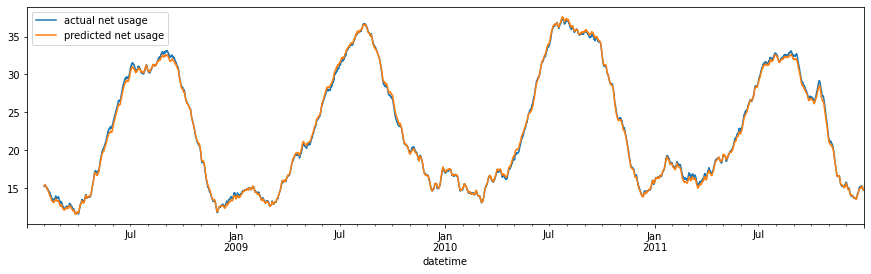

In [114]:
fig, ax = plt.subplots(figsize=(15,4))
df['net_load_kW'].rolling(24*30).mean().plot(label="actual net usage")
df['net_load_kW_poly_forecast'].rolling(24*30).mean().plot(label="predicted net usage")
plt.legend(loc='upper left')

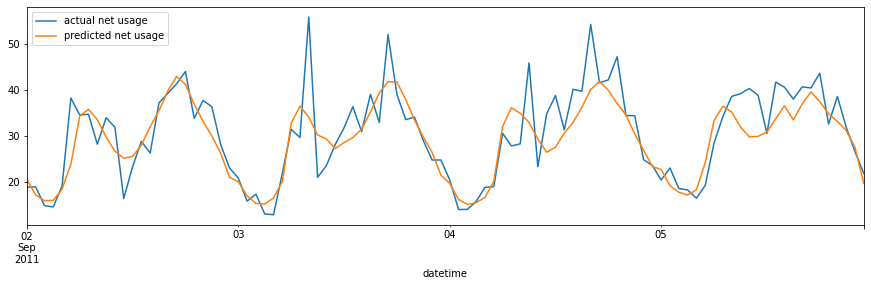

In [115]:
fig, ax = plt.subplots(figsize=(15,4))
df['net_load_kW'].loc['2011-09-02':'2011-09-05'].plot(label="actual net usage")
df['net_load_kW_poly_forecast'].loc['2011-09-02':'2011-09-05'].plot(label="predicted net usage")
plt.legend(loc='upper left')

### Using 24hr weather predictions to calculate net energy usage

In [116]:
X_forecast = df[['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift', 'hour', 'month']].dropna()
y_forecast = df['net_load_kW']

X_forecast_test = df_test[['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift', 'hour', 'month']].dropna()
y_forecast_test = df_test['net_load_kW']

poly_features_forecast = poly.fit_transform(X_forecast)
y_pred = poly_reg_model.predict(poly_features_forecast)

poly_features_test = poly.fit_transform(X_forecast_test)
y_pred_test = poly_reg_model.predict(poly_features_test)
df_test['net_load_kW_forecast'] = y_pred_test

# Calculate r-squared 
print("R-squared:", r2_score(y_forecast, y_pred).round(3))
df['net_load_kW_forecast'] = y_pred

R-squared: 0.838


In [117]:
print(f"Mean Absolute Error = {mean_absolute_error(y_test, y_pred_test).round(3)}")
print(f"Mean Squared Error = {mean_squared_error(y_test, y_pred_test).round(3)}")
print("MAPE =", mean_absolute_percentage_error(y_test, y_pred_test).round(3))

Mean Absolute Error = 3.659
Mean Squared Error = 24.081
MAPE = 119.918


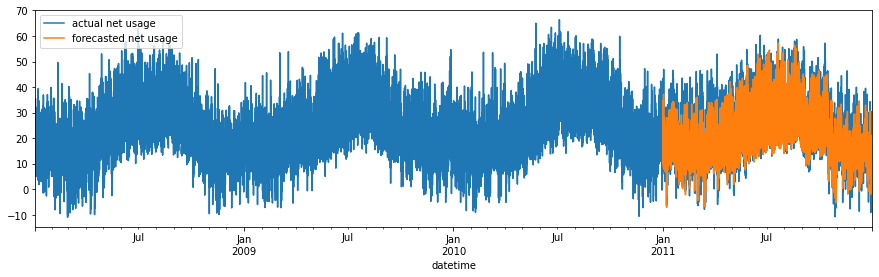

In [118]:
fig, ax = plt.subplots(figsize=(15,4))
df['net_load_kW'].plot(label="actual net usage")
df_test['net_load_kW_forecast'].plot(label="forecasted net usage")
plt.legend(loc='upper left')

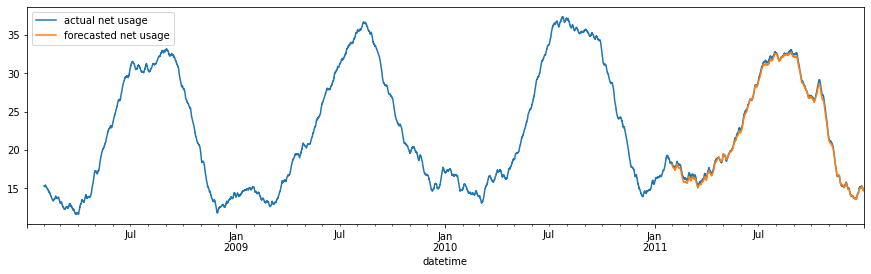

In [119]:
fig, ax = plt.subplots(figsize=(15,4))
df['net_load_kW'].rolling(24*30).mean().plot(label="actual net usage")
df_test['net_load_kW_forecast'].rolling(24*30).mean().plot(label="forecasted net usage")
plt.legend(loc='upper left')

<AxesSubplot:xlabel='datetime'>

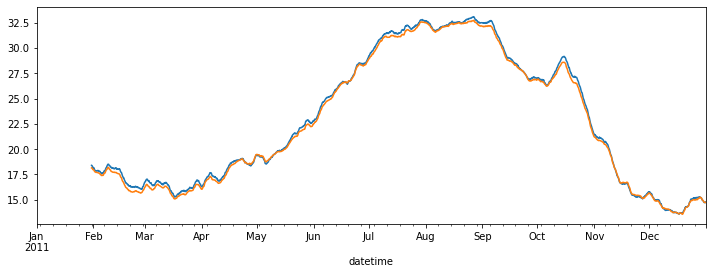

In [120]:
fig, ax = plt.subplots(figsize=(12,4))
df_test['net_load_kW'].rolling(24*30).mean().plot()
df_test['net_load_kW_forecast'].rolling(24*30).mean().plot()

<AxesSubplot:xlabel='datetime'>

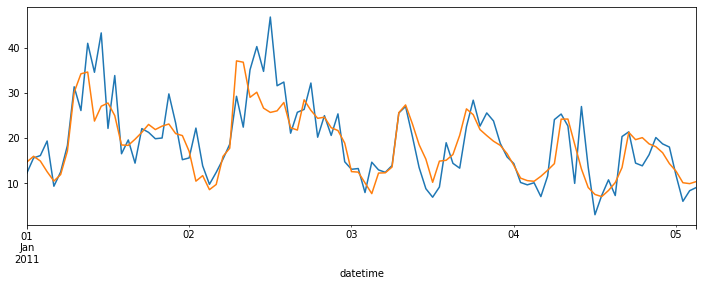

In [121]:
fig, ax = plt.subplots(figsize=(12,4))
df_test.iloc[0:100]['net_load_kW'].plot()
df_test.iloc[0:100]['net_load_kW_forecast'].plot()

## Regression using time-based features

In [122]:
features_list = ['month','hour','holiday','workday']

df_lr = df[features_list]
df_lr['year'] = df_lr.index.year
df_lr

df_lr['month'] = df_lr['month'].astype('category')
df_lr['hour'] = df_lr['hour'].astype('category')
df_lr['holiday'] = df_lr['holiday'].astype('category')
df_lr['workday'] = df_lr['workday'].astype('category')
df_lr['year'] = df_lr['year'].astype('category')

df_lr = pd.get_dummies(df_lr, drop_first=True)

y = df['net_load_kW']


In [123]:
X_train = df_lr.iloc[:(len(df_lr)-365*24)]   # First 3 years as train data
X_test = df_lr.iloc[(len(df_lr)-365*24):]    # Last year as test data

y_train = y.iloc[:(len(y)-365*24)]
y_test = y.iloc[(len(y)-365*24):]

In [124]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred_train = lm.predict(X_train)
df_train['y_pred_train'] = y_pred_train

y_pred_test = lm.predict(X_test)
df_test['y_pred_test'] = y_pred_test

y_pred = lm.predict(df_lr)
df_lr['y_pred'] = y_pred

#df['predicted'] = y_pred

In [125]:
print("R-squared (train):", r2_score(df_train['net_load_kW'], y_pred_train).round(3))
print("R-squared (test):", r2_score(df_test['net_load_kW'], y_pred_test).round(3))
print("Test MAPE:", round(mean_absolute_percentage_error(df_test['net_load_kW'], y_pred_test), 3))


R-squared (train): 0.66
R-squared (test): 0.518
Test MAPE: 261.731


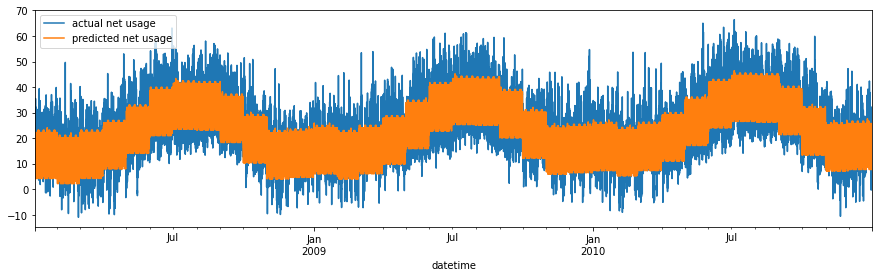

In [126]:
fig, ax = plt.subplots(figsize=(15,4))
df_train['net_load_kW'].plot(label="actual net usage")
df_train['y_pred_train'].plot(label="predicted net usage")
plt.legend(loc='upper left')

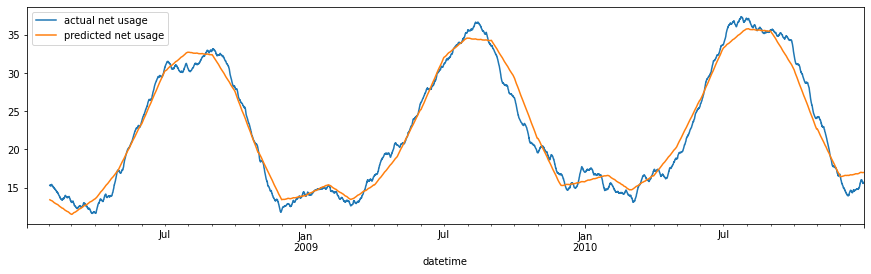

In [127]:
fig, ax = plt.subplots(figsize=(15,4))
df_train['net_load_kW'].rolling(30*24).mean().plot(label="actual net usage")
df_train['y_pred_train'].rolling(30*24).mean().plot(label="predicted net usage")
plt.legend(loc='upper left')

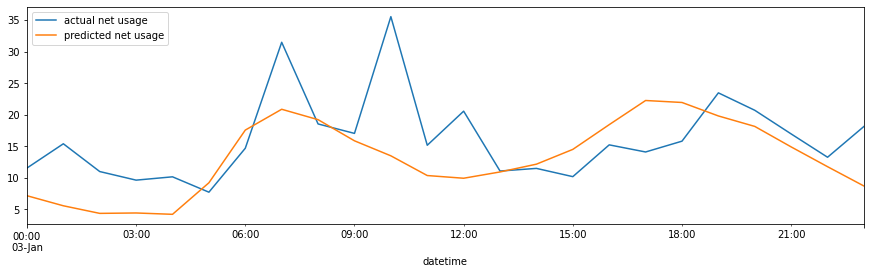

In [130]:
fig, ax = plt.subplots(figsize=(15,4))
df_train['net_load_kW'].loc['2008-01-03'].plot(label="actual net usage")
df_train['y_pred_train'].loc['2008-01-03'].plot(label="predicted net usage")
plt.legend(loc='upper left')

In [131]:
# DataFrame with row numbers as indices
df_index = df.reset_index()

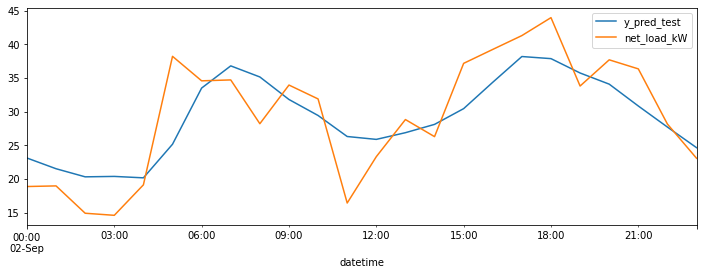

Mean Absolute Error (Linear regression) = 4.039
Mean Squared Error (Linear regression) = 25.025
R2 score (Linear regression) = 0.67
-----------------------------------


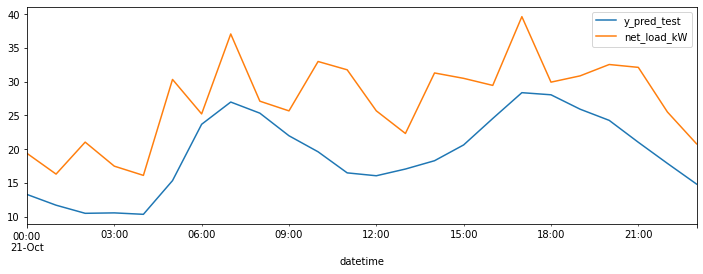

Mean Absolute Error (Linear regression) = 7.851
Mean Squared Error (Linear regression) = 77.527
R2 score (Linear regression) = -0.992
-----------------------------------


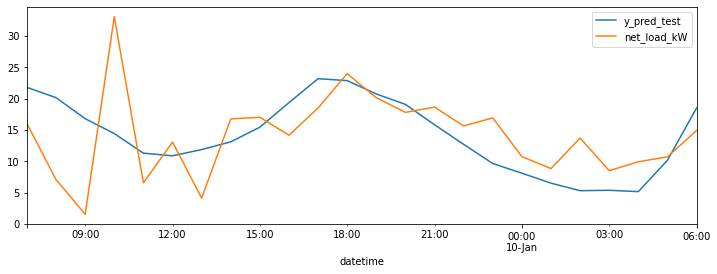

Mean Absolute Error (Linear regression) = 5.167
Mean Squared Error (Linear regression) = 47.476
R2 score (Linear regression) = -0.093
-----------------------------------


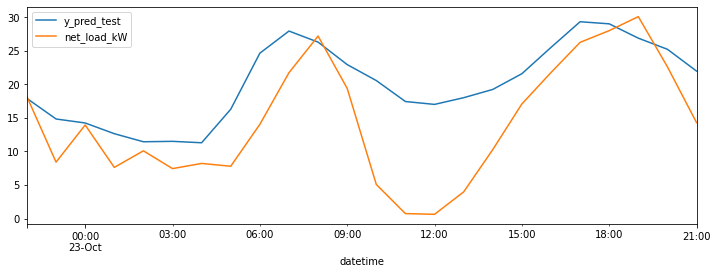

Mean Absolute Error (Linear regression) = 6.15
Mean Squared Error (Linear regression) = 63.141
R2 score (Linear regression) = 0.147
-----------------------------------


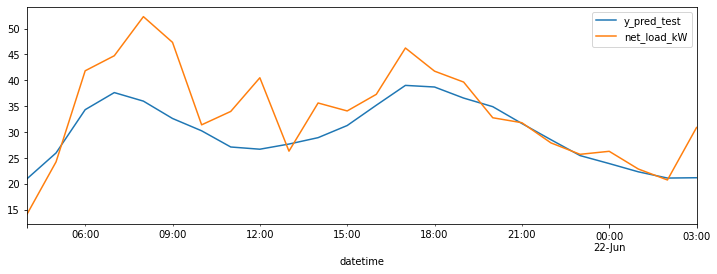

Mean Absolute Error (Linear regression) = 4.934
Mean Squared Error (Linear regression) = 46.311
R2 score (Linear regression) = 0.449
-----------------------------------


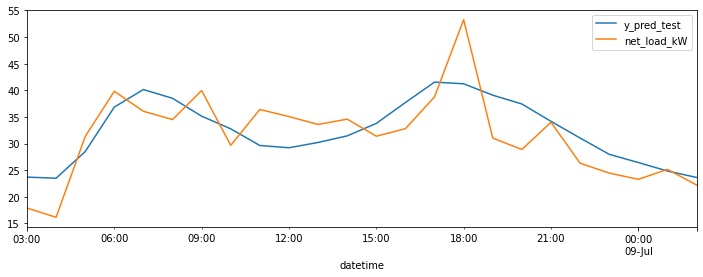

Mean Absolute Error (Linear regression) = 4.417
Mean Squared Error (Linear regression) = 26.551
R2 score (Linear regression) = 0.562
-----------------------------------


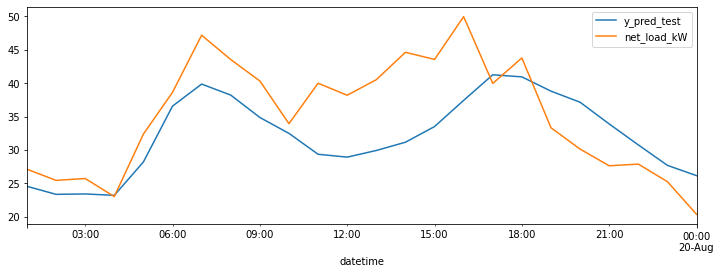

Mean Absolute Error (Linear regression) = 5.555
Mean Squared Error (Linear regression) = 44.83
R2 score (Linear regression) = 0.347
-----------------------------------


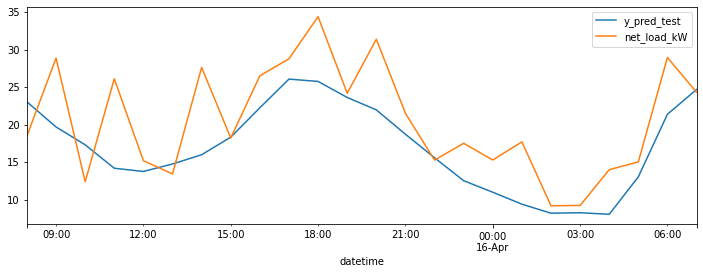

Mean Absolute Error (Linear regression) = 4.549
Mean Squared Error (Linear regression) = 34.103
R2 score (Linear regression) = 0.33
-----------------------------------


In [132]:
days_to_forecast = pd.to_datetime(['2011-09-01 23:00:00', '2011-10-20 23:00:00', 
                                   '2011-01-09 06:00:00', '2011-10-22 21:00:00', 
                                   '2011-06-21 03:00:00', '2011-07-08 02:00:00', 
                                   '2011-08-19 00:00:00', '2011-04-15 07:00:00'])

pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

forecasts = pd.DataFrame(columns=['runid','id','prediction'])
predictions = list()
for i in range(0,8):

  day = days_to_forecast[i]
  index = pred_indices[i]

  # Starting the MLFlow run
  #r = mlflow.start_run(run_name="linear_regression")
  #print("run-uuid:", r.info.run_uuid)

  start_hour = day+pd.DateOffset(hours=1)
  end_hour = day+pd.DateOffset(hours=24)
  forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
  y_pred = df_test['y_pred_test'][df_test.index.isin(forecast_hours)]
  y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

  fig, ax = plt.subplots(figsize=(12,4))
  df_test['y_pred_test'][df_test.index.isin(forecast_hours)].plot()
  df_test['net_load_kW'][df_test.index.isin(forecast_hours)].plot()
  plt.legend()
  plt.show()

  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Mean Absolute Error (Linear regression) = {mae.round(3)}")
  print(f"Mean Squared Error (Linear regression) = {mse.round(3)}")
  print(f"R2 score (Linear regression) = {r2.round(3)}")
  print("-----------------------------------")

  ##########
  # MLFLOW #
  ##########
  # for k, v in global_params.items():
  #   mlflow.log_param(k, v)
  #   mlflow.log_param("model", "linear_regression")
  #   mlflow.log_param("datetime", day)
  #   mlflow.log_param("feature", "net_load_kW")
  #   mlflow.log_metric("mse", mse)
  #   mlflow.log_metric("mae", mae)
  #   mlflow.log_metric("r2_score", r2)
  # mlflow.end_run()

  # day_forecast = pd.DataFrame(columns=['runid','id','prediction'])
  # day_forecast['prediction'] = df_lr['y_pred'].iloc[index+1:index+25]
  # day_forecast['runid'] = r.info.run_uuid
  # day_forecast['id'] = np.arange(index+1,index+25)
  # forecasts = pd.concat([forecasts, day_forecast], axis=0)

#forecasts.to_sql("forecast", con=db, if_exists="append")
  

<AxesSubplot:xlabel='datetime'>

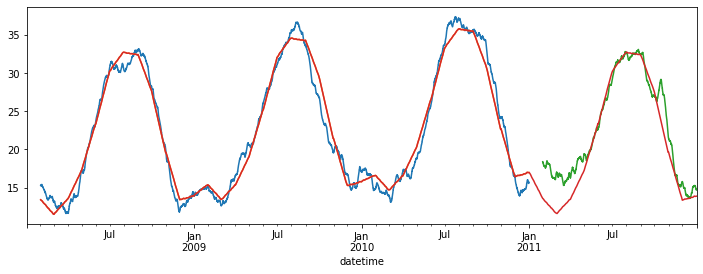

In [133]:
fig, ax = plt.subplots(figsize=(12,4))
df_train['net_load_kW'].rolling(24*30).mean().plot(ax=ax)
df_train['y_pred_train'].rolling(24*30).mean().plot(ax=ax)
df_test['net_load_kW'].rolling(24*30).mean().plot(ax=ax)
df_lr['y_pred'].rolling(24*30).mean().plot(ax=ax)


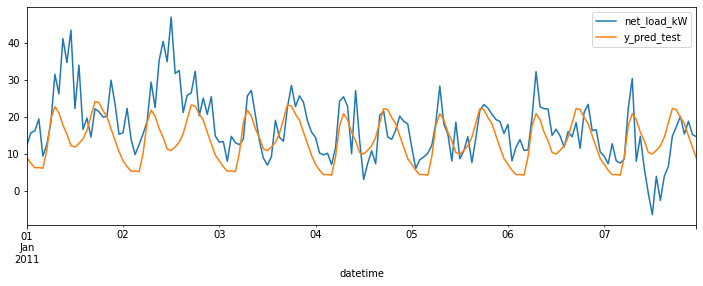

In [134]:
fig, ax = plt.subplots(figsize=(12,4))
df_test.iloc[0:24*7]['net_load_kW'].plot()
df_test.iloc[0:24*7]['y_pred_test'].plot()
plt.legend()